# Faster R-CNN

## MMDetection

In [1]:
!nvcc --version

/bin/bash: nvcc: команда не найдена


In [2]:
!gcc --version

gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
import torch
torch.cuda.empty_cache()

In [4]:
!nvidia-smi

Mon May  9 11:40:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P2    28W /  N/A |    389MiB /  6144MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

import mmdet
print(mmdet.__version__)

from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.11.0 True
2.24.1
11.3
GCC 9.4


In [6]:
%cd CourseWork/

/home/drapeykonik/CourseWork


## Inference

MMDetection обладает высокоуровневым API для реализации вычислений и обучени сети

Можно загрузить предобученную на датасете MS COCO модель Faster RCNN

И config-файл, и файл с весами загружен локально

Будем использовать методы API этого фреймворка для инициализации модели, тестирования и визуализации предсказаний

Faster R-CNN:

load checkpoint from local path: checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


/home/drapeykonik/anaconda3/envs/myenv/lib/python3.9/site-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


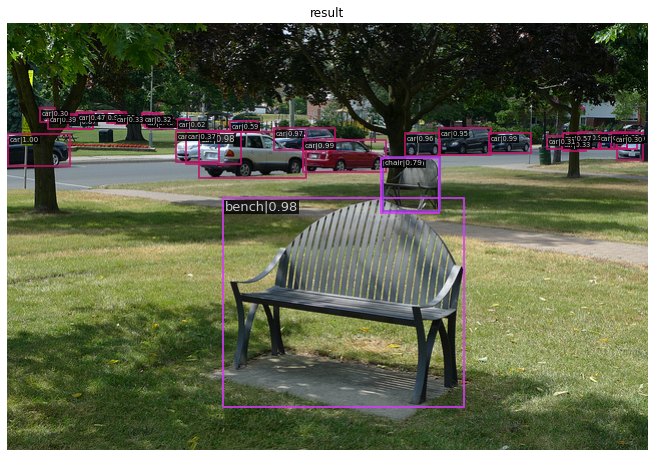

In [7]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

img = 'mmdetection/demo/demo.jpg'
config = 'mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py'
checkpoint = 'checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'
model = init_detector(config, checkpoint, device='cuda:0')
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

In [8]:
!ls checkpoints

faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth
ssd300_coco_20210803_015428-d231a06e.pth


## Training

Для выполнения обучения нового детектора нужно сделать три вещи:
1. Определить новый датасет
2. Изменить config
3. Выполнить обучение нового детектора

### Определение нового датасета

Есть три способа это сделать в MMDetection
1. Реорганизовать датасет в формат датасета COCO
2. Реорганизовать датасет в middle-формат
3. Реализовать новый датасет

Это было сделано в ноутбуке для обучения SSD300. Сначало был выбран третий подход, однако ввиду своей ошибочности (возможно), далее был применен первый. В папке с датасетом уже лежат файлы разметки, реорганизованные к виду MS COCO датасета

#### COCO format

In [9]:
import os.path as osp
import mmcv

def convert_numberplate_to_coco(ann_file, out_file, image_prefix):
    data_infos = mmcv.load(ann_file)["_via_img_metadata"]

    annotations = []
    images = []
    obj_count = 0
    for idx, v in enumerate(mmcv.track_iter_progress(data_infos.values())):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(dict(
            id=idx,
            file_name=filename,
            height=height,
            width=width))

        bboxes = []
        labels = []
        for obj in v['regions']:
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px = obj.get('all_points_x', [])
            py = obj.get('all_points_y', [])
            if len(px) == 0 and len(py) == 0:
              continue
            x_min, y_min, x_max, y_max = (
                min(px), min(py), max(px), max(py))
            
            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=(x_max - x_min) * (y_max - y_min),
                segmentation=None,
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{'id':0, 'name': 'numberplate'}])
    mmcv.dump(coco_format_json, out_file)

In [10]:
from mmcv import Config

model_type = "faster_rcnn"

if model_type == "faster_rcnn":
  cfg = Config.fromfile('mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py')

In [11]:
print(f'Config:\n{cfg.pretty_text}')

Config:
checkpoint_config = dict(interval=1)
log_config = dict(interval=50, hooks=[dict(type='TextLoggerHook')])
custom_hooks = [dict(type='NumClassCheckHook')]
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
auto_scale_lr = dict(enable=False, base_batch_size=16)
dataset_type = 'CocoDataset'
data_root = 'data/coco/'
img_norm_cfg = dict(
    mean=[103.53, 116.28, 123.675], std=[1.0, 1.0, 1.0], to_rgb=False)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='Resize',
        img_scale=[(1333, 640), (1333, 800)],
        multiscale_mode='range',
        keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[103.53, 116.28, 123.675],
        std=[1.0, 1.0, 1.0],
        to_rgb=False),
    dict(type='Pad', size_divisor=32),
    dict(type='Defa

In [12]:
from mmdet.apis import set_random_seed

# The new config inherits a base config to highlight the necessary modification
#_base_ = '/mmdetection/configs/ssd/ssd300_coco.py'

cfg.data_root = 'autoriaNumberplateDataset-2018-11-20/'
# We also need to change the num_classes in head to match the dataset's annotation
cfg.model.roi_head.bbox_head.num_classes = 1
cfg.model.train_cfg.rpn.sampler.num = 20

# Modify dataset related settings
cfg.dataset_type = 'COCODataset'
classes = ('numberplate',)

cfg.data.train.dataset.img_prefix='autoriaNumberplateDataset-2018-11-20/train/'
cfg.data.train.dataset.classes=classes
cfg.data.train.dataset.ann_file='autoriaNumberplateDataset-2018-11-20/train/numberplate_coco.json'

cfg.data.val.img_prefix='autoriaNumberplateDataset-2018-11-20/val/'
cfg.data.val.classes=classes
cfg.data.val.ann_file='autoriaNumberplateDataset-2018-11-20/val/numberplate_coco.json'

cfg.data.test.img_prefix='autoriaNumberplateDataset-2018-11-20/val/'
cfg.data.test.classes=classes
cfg.data.test.ann_file='autoriaNumberplateDataset-2018-11-20/val/numberplate_coco.json'

cfg.optimizer.lr = 0.02 / 8.  # 3e-3
#cfg.lr_config.warmup = None
cfg.lr_config.policy = 'step'
cfg.lr_config.warmup = 'linear'
cfg.lr_config.warmup_ratio = 1.0 / 1e10

cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
#cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
#cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 6

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = [0]
cfg.device = "cuda"

cfg.work_dir = f'./{model_type}_exps'
# We can use the pre-trained Mask RCNN model to obtain higher performance
cfg.load_from = 'checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'

In [13]:
print(f'Config:\n{cfg.pretty_text}')

Config:
checkpoint_config = dict(interval=6)
log_config = dict(interval=10, hooks=[dict(type='TextLoggerHook')])
custom_hooks = [dict(type='NumClassCheckHook')]
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'
resume_from = None
workflow = [('train', 1)]
opencv_num_threads = 0
mp_start_method = 'fork'
auto_scale_lr = dict(enable=False, base_batch_size=16)
dataset_type = 'COCODataset'
data_root = 'autoriaNumberplateDataset-2018-11-20/'
img_norm_cfg = dict(
    mean=[103.53, 116.28, 123.675], std=[1.0, 1.0, 1.0], to_rgb=False)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='Resize',
        img_scale=[(1333, 640), (1333, 800)],
        multiscale_mode='range',
        keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[103.53, 116.28, 123.675],
   

###Training

In [14]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector( cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


2022-05-09 11:42:09,045 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-05-09 11:42:09,151 - mmdet - INFO - load checkpoint from local path: checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


2022-05-09 11:42:09,283 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).
2022-05-09 11:42:09,285 - mmdet - INFO - Start running, host: drapeykonik@drapeykonik-AsusGL504GM, work_dir: /home/drapeykonik/CourseWork/faster_rcnn_exps
2022-05-09 11:42:09,285 - mmdet - INFO - Hooks will be executed in the following orde

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 375/375, 6.0 task/s, elapsed: 63s, ETA:     0s

2022-05-09 12:03:03,528 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-05-09 12:03:03,663 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.742
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.897
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.888
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.297
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.747
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.802
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.808
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.02s).


2022-05-09 12:03:12,621 - mmdet - INFO - Epoch [2][10/1688]	lr: 2.500e-03, eta: 3:37:33, time: 0.853, data_time: 0.218, memory: 3609, loss_rpn_cls: 0.0055, loss_rpn_bbox: 0.0834, loss_cls: 0.0139, acc: 99.4629, loss_bbox: 0.0188, loss: 0.1215
2022-05-09 12:03:19,291 - mmdet - INFO - Epoch [2][20/1688]	lr: 2.500e-03, eta: 3:37:22, time: 0.666, data_time: 0.046, memory: 3609, loss_rpn_cls: 0.0060, loss_rpn_bbox: 0.0735, loss_cls: 0.0088, acc: 99.7070, loss_bbox: 0.0182, loss: 0.1064
2022-05-09 12:03:26,281 - mmdet - INFO - Epoch [2][30/1688]	lr: 2.500e-03, eta: 3:37:15, time: 0.705, data_time: 0.047, memory: 3609, loss_rpn_cls: 0.0095, loss_rpn_bbox: 0.0471, loss_cls: 0.0194, acc: 99.4824, loss_bbox: 0.0246, loss: 0.1006
2022-05-09 12:03:32,945 - mmdet - INFO - Epoch [2][40/1688]	lr: 2.500e-03, eta: 3:37:05, time: 0.674, data_time: 0.041, memory: 3609, loss_rpn_cls: 0.0128, loss_rpn_bbox: 0.0608, loss_cls: 0.0138, acc: 99.4629, loss_bbox: 0.0212, loss: 0.1087
2022-05-09 12:03:39,917 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 375/375, 5.5 task/s, elapsed: 68s, ETA:     0s

2022-05-09 12:23:39,618 - mmdet - INFO - Evaluating bbox...
2022-05-09 12:23:39,737 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.897
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.884
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.404
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.776
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.830
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.830
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.830
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.825
 Average R

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).


2022-05-09 12:23:49,360 - mmdet - INFO - Epoch [3][10/1688]	lr: 2.500e-03, eta: 3:15:45, time: 0.917, data_time: 0.216, memory: 3609, loss_rpn_cls: 0.0091, loss_rpn_bbox: 0.0455, loss_cls: 0.0195, acc: 99.3848, loss_bbox: 0.0206, loss: 0.0948
2022-05-09 12:23:56,609 - mmdet - INFO - Epoch [3][20/1688]	lr: 2.500e-03, eta: 3:15:39, time: 0.727, data_time: 0.048, memory: 3609, loss_rpn_cls: 0.1559, loss_rpn_bbox: 0.1026, loss_cls: 0.0184, acc: 99.4434, loss_bbox: 0.0228, loss: 0.2997
2022-05-09 12:24:04,121 - mmdet - INFO - Epoch [3][30/1688]	lr: 2.500e-03, eta: 3:15:35, time: 0.756, data_time: 0.047, memory: 3609, loss_rpn_cls: 0.0266, loss_rpn_bbox: 0.0633, loss_cls: 0.0132, acc: 99.5312, loss_bbox: 0.0179, loss: 0.1209
2022-05-09 12:24:11,464 - mmdet - INFO - Epoch [3][40/1688]	lr: 2.500e-03, eta: 3:15:30, time: 0.728, data_time: 0.042, memory: 3609, loss_rpn_cls: 0.0272, loss_rpn_bbox: 0.0688, loss_cls: 0.0239, acc: 99.2676, loss_bbox: 0.0220, loss: 0.1419
2022-05-09 12:24:18,873 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 375/375, 6.0 task/s, elapsed: 63s, ETA:     0s

2022-05-09 12:44:35,057 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...


2022-05-09 12:44:35,182 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.892
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.779
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.837
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.837
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.837
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.250
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.839
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.02s).


2022-05-09 12:44:44,120 - mmdet - INFO - Epoch [4][10/1688]	lr: 2.500e-03, eta: 2:56:43, time: 0.851, data_time: 0.221, memory: 3609, loss_rpn_cls: 0.0162, loss_rpn_bbox: 0.0708, loss_cls: 0.0163, acc: 99.5508, loss_bbox: 0.0181, loss: 0.1214
2022-05-09 12:44:51,090 - mmdet - INFO - Epoch [4][20/1688]	lr: 2.500e-03, eta: 2:56:36, time: 0.699, data_time: 0.047, memory: 3609, loss_rpn_cls: 0.0069, loss_rpn_bbox: 0.0535, loss_cls: 0.0098, acc: 99.6777, loss_bbox: 0.0184, loss: 0.0885
2022-05-09 12:44:58,159 - mmdet - INFO - Epoch [4][30/1688]	lr: 2.500e-03, eta: 2:56:29, time: 0.697, data_time: 0.045, memory: 3609, loss_rpn_cls: 0.0106, loss_rpn_bbox: 0.0674, loss_cls: 0.0125, acc: 99.5312, loss_bbox: 0.0185, loss: 0.1090
2022-05-09 12:45:04,847 - mmdet - INFO - Epoch [4][40/1688]	lr: 2.500e-03, eta: 2:56:22, time: 0.689, data_time: 0.054, memory: 3609, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0592, loss_cls: 0.0126, acc: 99.4824, loss_bbox: 0.0195, loss: 0.0940
2022-05-09 12:45:11,644 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 375/375, 6.0 task/s, elapsed: 63s, ETA:     0s

2022-05-09 13:05:09,907 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).

2022-05-09 13:05:10,022 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.785
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.895
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.893
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.787
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.797
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.844
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.844
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.844
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.838
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000


Accumulating evaluation results...
DONE (t=0.02s).


2022-05-09 13:05:19,044 - mmdet - INFO - Epoch [5][10/1688]	lr: 2.500e-03, eta: 2:36:39, time: 0.861, data_time: 0.218, memory: 3609, loss_rpn_cls: 0.0050, loss_rpn_bbox: 0.0407, loss_cls: 0.0110, acc: 99.5703, loss_bbox: 0.0208, loss: 0.0776
2022-05-09 13:05:25,931 - mmdet - INFO - Epoch [5][20/1688]	lr: 2.500e-03, eta: 2:36:32, time: 0.687, data_time: 0.045, memory: 3609, loss_rpn_cls: 0.0089, loss_rpn_bbox: 0.0546, loss_cls: 0.0117, acc: 99.5215, loss_bbox: 0.0202, loss: 0.0955
2022-05-09 13:05:32,798 - mmdet - INFO - Epoch [5][30/1688]	lr: 2.500e-03, eta: 2:36:25, time: 0.688, data_time: 0.046, memory: 3609, loss_rpn_cls: 0.0050, loss_rpn_bbox: 0.0528, loss_cls: 0.0213, acc: 99.3750, loss_bbox: 0.0241, loss: 0.1032
2022-05-09 13:05:39,535 - mmdet - INFO - Epoch [5][40/1688]	lr: 2.500e-03, eta: 2:36:18, time: 0.680, data_time: 0.045, memory: 3609, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0409, loss_cls: 0.0094, acc: 99.5898, loss_bbox: 0.0168, loss: 0.0699
2022-05-09 13:05:46,734 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 375/375, 5.3 task/s, elapsed: 71s, ETA:     0s

2022-05-09 13:26:01,457 - mmdet - INFO - Evaluating bbox...
2022-05-09 13:26:01,578 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.797
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.904
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.891
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.795
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.805
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.854
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.854
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.854
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.848
 Average R

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).


2022-05-09 13:26:11,739 - mmdet - INFO - Epoch [6][10/1688]	lr: 2.500e-03, eta: 2:17:04, time: 0.970, data_time: 0.220, memory: 3609, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0493, loss_cls: 0.0077, acc: 99.7266, loss_bbox: 0.0139, loss: 0.0736
2022-05-09 13:26:19,269 - mmdet - INFO - Epoch [6][20/1688]	lr: 2.500e-03, eta: 2:16:57, time: 0.747, data_time: 0.050, memory: 3609, loss_rpn_cls: 0.0055, loss_rpn_bbox: 0.0491, loss_cls: 0.0259, acc: 99.2578, loss_bbox: 0.0230, loss: 0.1034
2022-05-09 13:26:27,018 - mmdet - INFO - Epoch [6][30/1688]	lr: 2.500e-03, eta: 2:16:52, time: 0.786, data_time: 0.056, memory: 3609, loss_rpn_cls: 0.0085, loss_rpn_bbox: 0.0404, loss_cls: 0.0090, acc: 99.7070, loss_bbox: 0.0181, loss: 0.0761
2022-05-09 13:26:34,566 - mmdet - INFO - Epoch [6][40/1688]	lr: 2.500e-03, eta: 2:16:45, time: 0.762, data_time: 0.045, memory: 3609, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0435, loss_cls: 0.0083, acc: 99.6387, loss_bbox: 0.0156, loss: 0.0693
2022-05-09 13:26:41,742 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 375/375, 6.0 task/s, elapsed: 63s, ETA:     0s

2022-05-09 13:46:56,843 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-05-09 13:46:56,964 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.904
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.892
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.757
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.819
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.819
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.819
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.02s).


2022-05-09 13:47:05,926 - mmdet - INFO - Epoch [7][10/1688]	lr: 2.500e-03, eta: 1:57:37, time: 0.854, data_time: 0.217, memory: 3609, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0247, loss_cls: 0.0099, acc: 99.6191, loss_bbox: 0.0226, loss: 0.0586
2022-05-09 13:47:13,237 - mmdet - INFO - Epoch [7][20/1688]	lr: 2.500e-03, eta: 1:57:30, time: 0.729, data_time: 0.046, memory: 3609, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0487, loss_cls: 0.0139, acc: 99.5508, loss_bbox: 0.0228, loss: 0.0884
2022-05-09 13:47:20,223 - mmdet - INFO - Epoch [7][30/1688]	lr: 2.500e-03, eta: 1:57:23, time: 0.700, data_time: 0.048, memory: 3609, loss_rpn_cls: 0.0061, loss_rpn_bbox: 0.0466, loss_cls: 0.0223, acc: 99.3555, loss_bbox: 0.0278, loss: 0.1028
2022-05-09 13:47:26,826 - mmdet - INFO - Epoch [7][40/1688]	lr: 2.500e-03, eta: 1:57:16, time: 0.673, data_time: 0.047, memory: 3609, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0533, loss_cls: 0.0097, acc: 99.6582, loss_bbox: 0.0198, loss: 0.0846
2022-05-09 13:47:33,765 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 375/375, 5.3 task/s, elapsed: 70s, ETA:     0s

2022-05-09 14:08:33,652 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...


2022-05-09 14:08:33,804 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.790
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.907
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.893
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.791
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.795
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.849
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.849
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.849
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.844
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.03s).


2022-05-09 14:08:43,502 - mmdet - INFO - Epoch [8][10/1688]	lr: 2.500e-03, eta: 1:38:30, time: 0.925, data_time: 0.222, memory: 3609, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0471, loss_cls: 0.0093, acc: 99.6191, loss_bbox: 0.0170, loss: 0.0763
2022-05-09 14:08:51,079 - mmdet - INFO - Epoch [8][20/1688]	lr: 2.500e-03, eta: 1:38:23, time: 0.756, data_time: 0.049, memory: 3609, loss_rpn_cls: 0.0117, loss_rpn_bbox: 0.0495, loss_cls: 0.0129, acc: 99.4922, loss_bbox: 0.0178, loss: 0.0919
2022-05-09 14:08:58,262 - mmdet - INFO - Epoch [8][30/1688]	lr: 2.500e-03, eta: 1:38:17, time: 0.725, data_time: 0.050, memory: 3609, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0368, loss_cls: 0.0226, acc: 99.0820, loss_bbox: 0.0209, loss: 0.0817
2022-05-09 14:09:05,445 - mmdet - INFO - Epoch [8][40/1688]	lr: 2.500e-03, eta: 1:38:10, time: 0.725, data_time: 0.044, memory: 3609, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0366, loss_cls: 0.0109, acc: 99.5605, loss_bbox: 0.0195, loss: 0.0685
2022-05-09 14:09:12,773 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 375/375, 5.4 task/s, elapsed: 70s, ETA:     0s

2022-05-09 14:30:29,235 - mmdet - INFO - Evaluating bbox...
2022-05-09 14:30:29,389 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.797
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.889
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.793
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.859
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.859
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.859
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.856
 Average R

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).


2022-05-09 14:30:39,182 - mmdet - INFO - Epoch [9][10/1688]	lr: 2.500e-03, eta: 1:19:15, time: 0.934, data_time: 0.222, memory: 3609, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0276, loss_cls: 0.0076, acc: 99.7949, loss_bbox: 0.0163, loss: 0.0527
2022-05-09 14:30:46,743 - mmdet - INFO - Epoch [9][20/1688]	lr: 2.500e-03, eta: 1:19:08, time: 0.757, data_time: 0.049, memory: 3609, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0575, loss_cls: 0.0114, acc: 99.5703, loss_bbox: 0.0192, loss: 0.0906
2022-05-09 14:30:54,749 - mmdet - INFO - Epoch [9][30/1688]	lr: 2.500e-03, eta: 1:19:01, time: 0.798, data_time: 0.049, memory: 3609, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0390, loss_cls: 0.0113, acc: 99.5898, loss_bbox: 0.0179, loss: 0.0717
2022-05-09 14:31:01,879 - mmdet - INFO - Epoch [9][40/1688]	lr: 2.500e-03, eta: 1:18:54, time: 0.728, data_time: 0.051, memory: 3609, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0290, loss_cls: 0.0080, acc: 99.7461, loss_bbox: 0.0159, loss: 0.0540
2022-05-09 14:31:08,961 - mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 375/375, 5.5 task/s, elapsed: 68s, ETA:     0s

2022-05-09 14:52:29,710 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...


2022-05-09 14:52:29,876 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.785
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.887
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.177
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.784
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.794
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.846
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.846
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.846
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.843
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.03s).


2022-05-09 14:52:39,318 - mmdet - INFO - Epoch [10][10/1688]	lr: 2.500e-04, eta: 0:59:43, time: 0.900, data_time: 0.223, memory: 3609, loss_rpn_cls: 0.0119, loss_rpn_bbox: 0.0530, loss_cls: 0.0118, acc: 99.4238, loss_bbox: 0.0165, loss: 0.0932
2022-05-09 14:52:46,842 - mmdet - INFO - Epoch [10][20/1688]	lr: 2.500e-04, eta: 0:59:36, time: 0.748, data_time: 0.049, memory: 3609, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0374, loss_cls: 0.0126, acc: 99.5605, loss_bbox: 0.0177, loss: 0.0707
2022-05-09 14:52:54,618 - mmdet - INFO - Epoch [10][30/1688]	lr: 2.500e-04, eta: 0:59:29, time: 0.778, data_time: 0.053, memory: 3609, loss_rpn_cls: 0.0011, loss_rpn_bbox: 0.0342, loss_cls: 0.0074, acc: 99.7852, loss_bbox: 0.0150, loss: 0.0578
2022-05-09 14:53:02,744 - mmdet - INFO - Epoch [10][40/1688]	lr: 2.500e-04, eta: 0:59:22, time: 0.827, data_time: 0.053, memory: 3609, loss_rpn_cls: 0.0059, loss_rpn_bbox: 0.0334, loss_cls: 0.0083, acc: 99.7461, loss_bbox: 0.0152, loss: 0.0627
2022-05-09 14:53:10,683 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 375/375, 5.0 task/s, elapsed: 76s, ETA:     0s

2022-05-09 15:15:51,427 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...


2022-05-09 15:15:51,595 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.807
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.905
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.891
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.404
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.800
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.819
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.866
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.866
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.866
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.858
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.03s).


2022-05-09 15:16:01,595 - mmdet - INFO - Epoch [11][10/1688]	lr: 2.500e-04, eta: 0:40:11, time: 0.952, data_time: 0.229, memory: 3609, loss_rpn_cls: 0.0036, loss_rpn_bbox: 0.0297, loss_cls: 0.0126, acc: 99.5410, loss_bbox: 0.0143, loss: 0.0602
2022-05-09 15:16:09,514 - mmdet - INFO - Epoch [11][20/1688]	lr: 2.500e-04, eta: 0:40:03, time: 0.787, data_time: 0.052, memory: 3609, loss_rpn_cls: 0.0103, loss_rpn_bbox: 0.0460, loss_cls: 0.0180, acc: 99.2578, loss_bbox: 0.0174, loss: 0.0918
2022-05-09 15:16:17,727 - mmdet - INFO - Epoch [11][30/1688]	lr: 2.500e-04, eta: 0:39:57, time: 0.825, data_time: 0.057, memory: 3609, loss_rpn_cls: 0.0008, loss_rpn_bbox: 0.0205, loss_cls: 0.0056, acc: 99.7949, loss_bbox: 0.0108, loss: 0.0378
2022-05-09 15:16:26,145 - mmdet - INFO - Epoch [11][40/1688]	lr: 2.500e-04, eta: 0:39:50, time: 0.845, data_time: 0.053, memory: 3609, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0205, loss_cls: 0.0121, acc: 99.5215, loss_bbox: 0.0178, loss: 0.0515
2022-05-09 15:16:34,292 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 375/375, 5.5 task/s, elapsed: 69s, ETA:     0s

2022-05-09 15:38:01,382 - mmdet - INFO - Evaluating bbox...
2022-05-09 15:38:01,535 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.906
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.892
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.404
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.809
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.869
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.869
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.869
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.865
 Average R

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.12s).
Accumulating evaluation results...
DONE (t=0.03s).


2022-05-09 15:38:10,650 - mmdet - INFO - Epoch [12][10/1688]	lr: 2.500e-05, eta: 0:20:06, time: 0.869, data_time: 0.222, memory: 3609, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0231, loss_cls: 0.0150, acc: 99.4043, loss_bbox: 0.0181, loss: 0.0584
2022-05-09 15:38:17,999 - mmdet - INFO - Epoch [12][20/1688]	lr: 2.500e-05, eta: 0:19:58, time: 0.733, data_time: 0.047, memory: 3609, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0317, loss_cls: 0.0175, acc: 99.3652, loss_bbox: 0.0185, loss: 0.0689
2022-05-09 15:38:25,496 - mmdet - INFO - Epoch [12][30/1688]	lr: 2.500e-05, eta: 0:19:51, time: 0.753, data_time: 0.049, memory: 3609, loss_rpn_cls: 0.0171, loss_rpn_bbox: 0.0410, loss_cls: 0.0156, acc: 99.3457, loss_bbox: 0.0212, loss: 0.0948
2022-05-09 15:38:32,426 - mmdet - INFO - Epoch [12][40/1688]	lr: 2.500e-05, eta: 0:19:44, time: 0.704, data_time: 0.046, memory: 3609, loss_rpn_cls: 0.0005, loss_rpn_bbox: 0.0224, loss_cls: 0.0104, acc: 99.6094, loss_bbox: 0.0156, loss: 0.0489
2022-05-09 15:38:39,621 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 375/375, 5.6 task/s, elapsed: 67s, ETA:     0s

2022-05-09 15:59:45,151 - mmdet - INFO - Evaluating bbox...
2022-05-09 15:59:45,289 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.905
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.900
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.404
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.808
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.817
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.871
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.871
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.871
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.869
 Average R

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.03s).


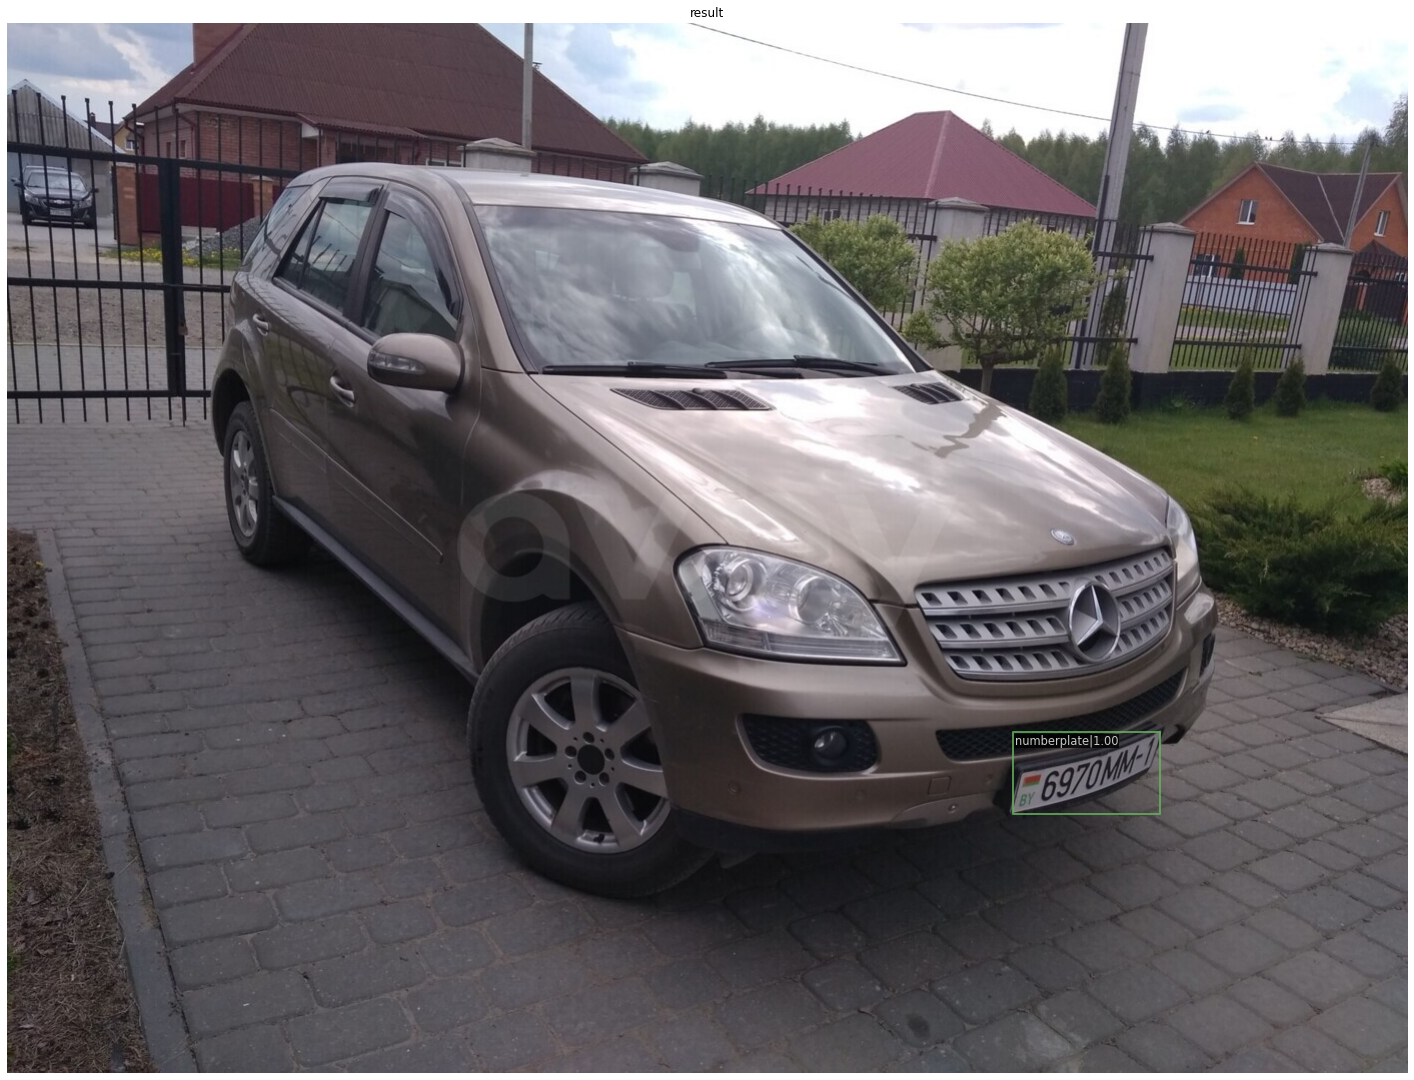

In [15]:
img = mmcv.imread('example_images/ex1.jpg')
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

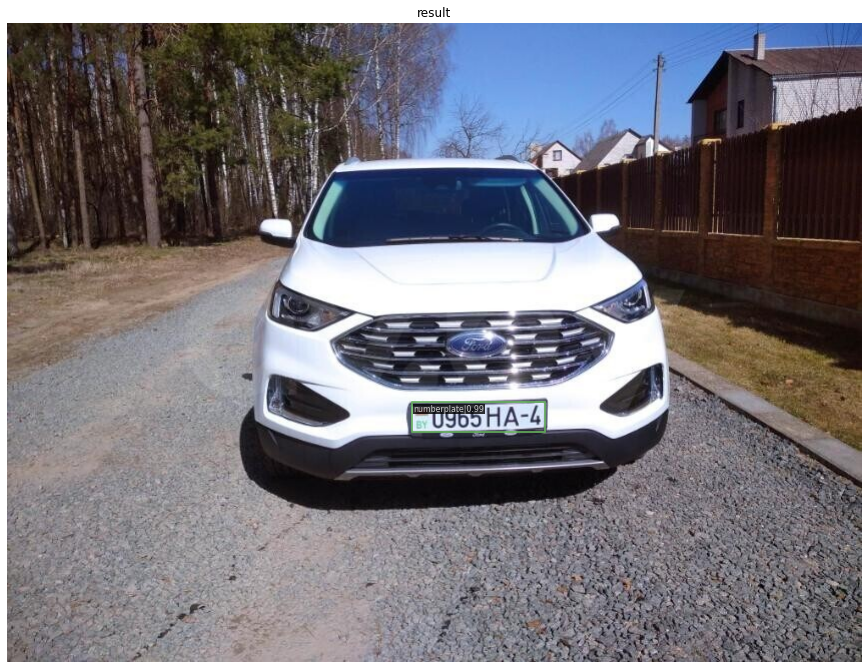

In [16]:
img = mmcv.imread('example_images/ex3.jpg')
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)